# Rossmann Store Sales Forecast

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
This notebook mainly focuses on the Time Series Analysis (seasonal decomposition, trends, autocorrelation).
We then disscuss advantages and drawbacks of modeling with Seasonal ARIMA and Prophet.


#### Approach:
    
I first do the habitual data treatment and cleansing.
In order to understand better the patterns of the data, I will make use of libraries like matplotlib and seaborn to deep dive cases in the dataset and give better visibility on what is happening with the different types of Rossman drug stores.
This Exploratory analysis will help me move forward with the correlation analysis and feature engineering part of the project.

#### Dataset:

<li>https://www.kaggle.com/c/rossmann-store-sales</li>

# Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# statistics
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


C:\DataScience\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Loading Dataset

In [2]:
# additional store data

store = pd.read_csv("Data/store.csv")
store.describe()
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [3]:
# importing train data

train = pd.read_csv("Data/train.csv", parse_dates = True, low_memory = False, index_col = 'Date')
train.describe()
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

#### A quick glimpse at the data:

- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.
    
We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [4]:
# data extraction

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: int64(11), object(1)
memory usage: 120.9+ MB


In [6]:
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  
Date                                                     
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31

In [7]:
# adding new variable

train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

##### In this section we go through the train and store data, handle missing values and create new features for further analysis.

In [8]:
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [9]:
train.fillna(0, inplace = True)

#### ECDF: empirical cumulative distribution function
To get the first impression about continious variables in the data we can plot ECDF.

In [10]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

##### Missing values
##### Closed stores and zero sales stores

In [11]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)]

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   
2015-07-29    876          3      0          0     0      1            0   
2015-07-28    292          2      0          0     0      1            0   
2015-07-28    876          2      0          0     0      1            0   
2015-07-27    292          1      0          0     0      1            0   
2015-07-27    876          1      0          0     0      1            0   
2015-07-26      1          7      0          0     0      0            0   
2015-07-26      2          7      0          0     0      0            0   
2015-07-26      3          7      0          0     0      0            0   
2015-07-26      4          7      0          0     0      0            0   
2015-07-26      5          7      0          0     0      0            0   
2015-07-26      6          7      0          0     0      0            0   
2015-07-26      7          7      0          0     0      0            0   
2015-07-26      8          7      0          0     0      0            0   
2015-07-26      9          7      0          0     0      0            0   
2015-07-26     10          7      0          0     0      0            0   
2015-07-26     11          7      0          0     0      0            0   
2015-07-26     12          7      0          0     0      0            0   
2015-07-26     13          7      0          0     0      0            0   
2015-07-26     14          7      0          0     0      0            0   
2015-07-26     15          7      0          0     0      0            0   
2015-07-26     16          7      0          0     0      0            0   
2015-07-26     17          7      0          0     0      0            0   
2015-07-26     18          7      0          0     0      0            0   
2015-07-26     19          7      0          0     0      0            0   
2015-07-26     20          7      0          0     0      0            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-01   1085          2      0          0     0      0            a   
2013-01-01   1086          2      0          0     0      0            a   
2013-01-01   1087          2      0          0     0      0            a   
2013-01-01   1088          2      0          0     0      0            a   
2013-01-01   1089          2      0          0     0      0            a   
2013-01-01   1090          2      0          0     0      0            a   
2013-01-01   1091          2      0          0     0      0            a   
2013-01-01   1092          2      0          0     0      0            a   
2013-01-01   1093          2      0          0     0      0            a   
2013-01-01   1094          2      0          0     0      0            a   
2013-01-01   1095          2      0          0     0      0            a   
2013-01-01   1096          2      0          0     0      0            a   
2013-01-01   1098          2      0          0     0      0            a   
2013-01-01   1099          2      0          0     0      0            a   
2013-01-01   1100          2      0          0     0      0            a   
2013-01-01   1101          2      0          0     0      0            a   
2013-01-01   1102          2      0          0     0      0            a   
2013-01-01   1103          2      0          0     0      0            a   
2013-01-01   1104          2      0          0     0      0            a   
2013-01-01   1105          2      0          0     0      0 

There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [12]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-05-15    971          5      0          0     1      0            0   
2015-03-26    674          4      0          0     1      0            0   
2015-02-05    699          4      0          0     1      1            0   
2014-10-01    708          3      0          0     1      1            0   
2014-09-22    357          1      0          0     1      0            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
Date                                                                      
2015-05-15              1  2015      5   15          20              0.0  
2015-03-26              0  2015      3   26          13              0.0  
2015-02-05              0  2015      2    5           6              0.0  
2014-10-01              0  2014     10    1          40              0.0  
2014-09-22              0  2014      9   22          39              0.0

Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [13]:
#print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

In total:  (844338, 13)


In [14]:
train=train.drop(columns=train[(train.Open == 1) & (train.Sales == 0)].index)

In [15]:
{"Mean":np.mean(train.Sales),"Median":np.median(train.Sales)}

{'Mean': 6955.959133664481, 'Median': 6369.0}

In [16]:
train.Customers.describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

In [17]:
{"Mean":np.mean(train.Customers),"Median":np.median(train.Customers)}

{'Mean': 762.777166253325, 'Median': 676.0}

### store.csv file EDA

In [18]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

1. Store: a unique Id for each store
2. StoreType: differentiates between 4 different store models: a, b, c, d
3. Assortment: describes an assortment level: a = basic, b = extra, c = extended
4. CompetitionDistance: distance in meters to the nearest competitor store
5. CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
6. Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
7. Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
8. PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started.
    E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [19]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [20]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]


Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [21]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data. What about Promo2SinceWeek?

In [22]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.

In [23]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [24]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head(1000)


Joining train set with an additional store information.
In total:  (844338, 22)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0        1          5   5263        555     1      1            0   
1        1          4   5020        546     1      1            0   
2        1          3   4782        523     1      1            0   
3        1          2   5011        560     1      1            0   
4        1          1   6102        612     1      1            0   
5        1          6   4364        500     1      0            0   
6        1          5   3706        459     1      0            0   
7        1          4   3769        503     1      0            0   
8        1          3   3464        463     1      0            0   
9        1          2   3558        469     1      0            0   
10       1          1   4395        526     1      0            0   
11       1          6   4406        512     1      0            0   
12       1          5   4852        519     1      1            0   
13       1          4   4427        517     1      1            0   
14       1          3   4767        550     1      1            0   
15       1          2   5042        544     1      1            0   
16       1          1   5054        553     1      1            0   
17       1          6   3530        441     1      0            0   
18       1          5   3808        449     1      0            0   
19       1          4   3897        480     1      0            0   
20       1          3   3797        485     1      0            0   
21       1          2   3650        485     1      0            0   
22       1          1   4359        540     1      0            0   
23       1          6   4797        560     1      0            0   
24       1          5   4665        538     1      1            0   
25       1          4   5558        573     1      1            0   
26       1          3   5223        562     1      1            0   
27       1          2   5735        568     1      1            0   
28       1          1   5197        541     1      1            0   
29       1          6   4019        463     1      0            0   
..     ...        ...    ...        ...   ...    ...          ...   
970      2          6   3375        350     1      0            0   
971      2          5   4407        497     1      0            0   
972      2          4   4629        539     1      0            0   
973      2          3   5830        717     1      0            0   
974      2          2   5264        596     1      0            0   
975      2          1   4821        616     1      0            0   
976      2          6   2914        386     1      0            0   
977      2          5   6385        676     1      1            0   
978      2          4   6661        670     1      1            0   
979      2          3   7533        769     1      1            0   
980      2          2   7664        751     1      1            0   
981      2          1   8674        783     1      1            0   
982      2          6   3424        372     1      0            0   
983      2          5   6062        608     1      1            0   
984      2          4   6119        644     1      1            0   
985      2          3   7588        828     1      1            0   
986      2          2   6511        632     1      1            0   
987      2          1   7038        696     1      1            0   
988      2          6   3085        367     1      0            0   
989      2          5   3978        472     1      0            0   
990      2          4   4527        535     1      0            0   
991      2          3   5091        674     1      0            0   
992      2          2   3468        411     1      0            0   
993      2          1   4157        552     1      0            0   
994      2          6   2979        373     1      0            0   
995      2          5   4655        560     1      1            0   
996

In [25]:
train_store.head(100)

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0       1          5   5263        555     1      1            0   
1       1          4   5020        546     1      1            0   
2       1          3   4782        523     1      1            0   
3       1          2   5011        560     1      1            0   
4       1          1   6102        612     1      1            0   
5       1          6   4364        500     1      0            0   
6       1          5   3706        459     1      0            0   
7       1          4   3769        503     1      0            0   
8       1          3   3464        463     1      0            0   
9       1          2   3558        469     1      0            0   
10      1          1   4395        526     1      0            0   
11      1          6   4406        512     1      0            0   
12      1          5   4852        519     1      1            0   
13      1          4   4427        517     1      1            0   
14      1          3   4767        550     1      1            0   
15      1          2   5042        544     1      1            0   
16      1          1   5054        553     1      1            0   
17      1          6   3530        441     1      0            0   
18      1          5   3808        449     1      0            0   
19      1          4   3897        480     1      0            0   
20      1          3   3797        485     1      0            0   
21      1          2   3650        485     1      0            0   
22      1          1   4359        540     1      0            0   
23      1          6   4797        560     1      0            0   
24      1          5   4665        538     1      1            0   
25      1          4   5558        573     1      1            0   
26      1          3   5223        562     1      1            0   
27      1          2   5735        568     1      1            0   
28      1          1   5197        541     1      1            0   
29      1          6   4019        463     1      0            0   
..    ...        ...    ...        ...   ...    ...          ...   
70      1          4   4529        491     1      1            0   
71      1          3   4960        536     1      1            0   
72      1          2   4564        514     1      1            0   
73      1          1   5591        589     1      1            0   
74      1          6   5850        653     1      0            0   
75      1          4   6228        650     1      1            0   
76      1          3   5775        579     1      1            0   
77      1          2   5199        552     1      1            0   
78      1          1   5575        574     1      1            0   
79      1          6   4318        537     1      0            0   
80      1          5   3198        437     1      0            0   
81      1          4   3076        426     1      0            0   
82      1          3   3319        411     1      0            0   
83      1          2   3037        416     1      0            0   
84      1          1   3722        480     1      0            0   
85      1          6   4594        544     1      0            0   
86      1          5   4718        511     1      1            0   
87      1          4   4116        480     1      1            0   
88      1          3   4110        501     1      1            0   
89      1          2   4648        535     1      1            0   
90      1          1   5377        574     1      1            0   
91      1          6   4173        525     1      0            0   
92      1          5   3549        428     1      0            0   
93      1          4   3467        430     1      0            0   
94      1          3   4194        500     1      0            0   
95      1          2   4163        555     1      0            0   
96      1          6   6709        796     1      0         

#### Store types
In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [26]:
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [27]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943

Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

C:\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


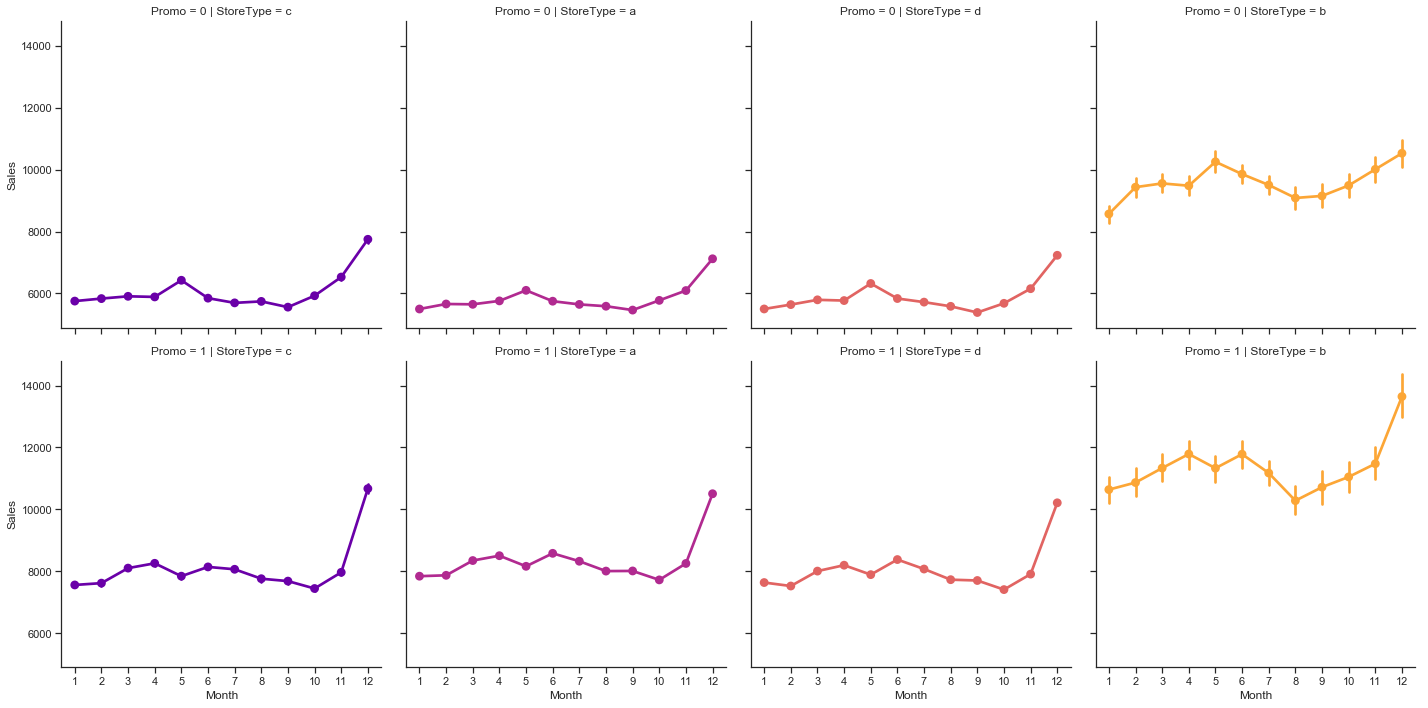

In [28]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

In [29]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', 
               color = c)

C:\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).

###### Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.

C:\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


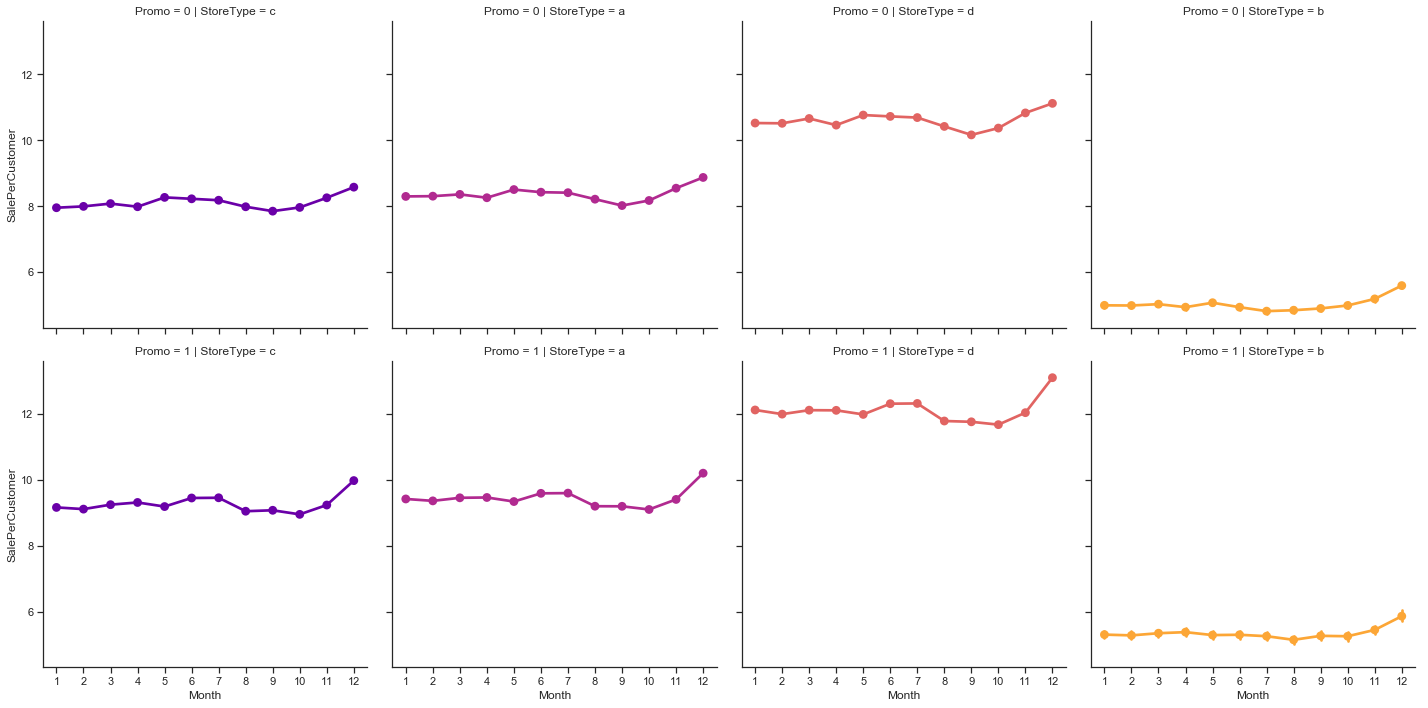

In [30]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D. 

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

C:\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


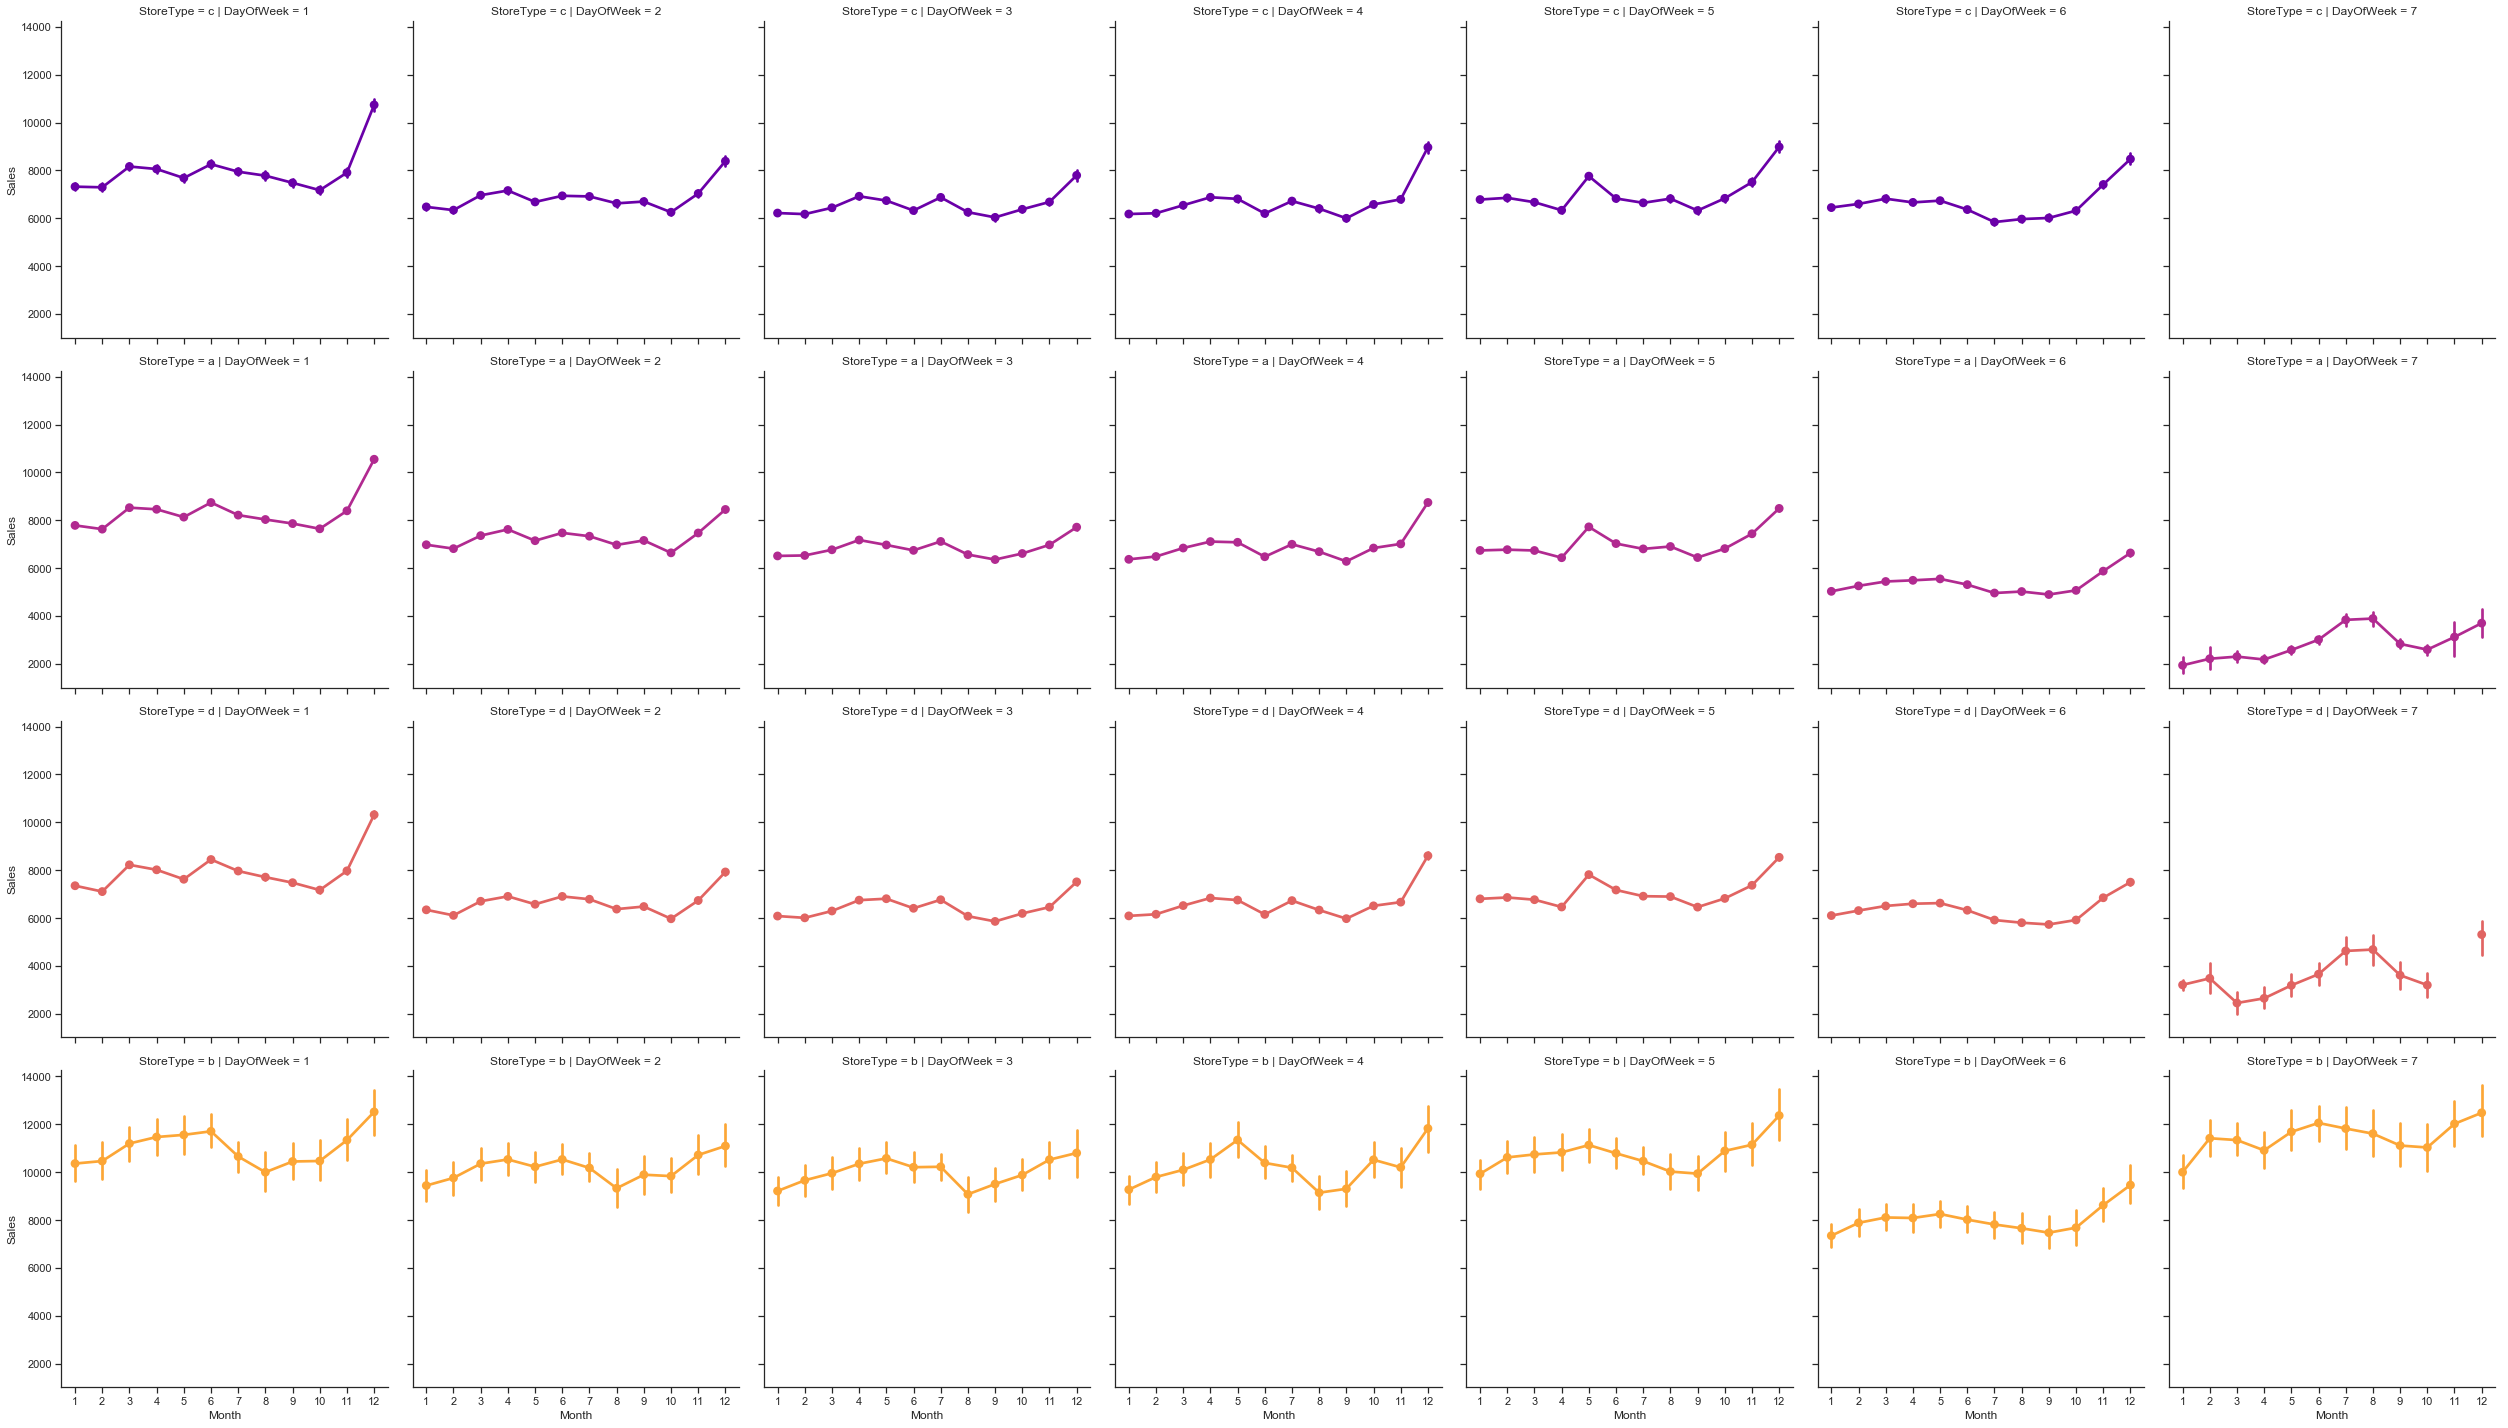

In [31]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma', 
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [32]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [33]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers     PromoOpen  CompetitionOpen
StoreType                                                          
a           6925.697986   795.422370  12918.492198      7115.514452
b          10233.380141  2022.211825  17199.328069     11364.495244
c           6933.126425   815.538073  12158.636107      6745.418694
d           6822.300064   606.353935  10421.916846      9028.526526

The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

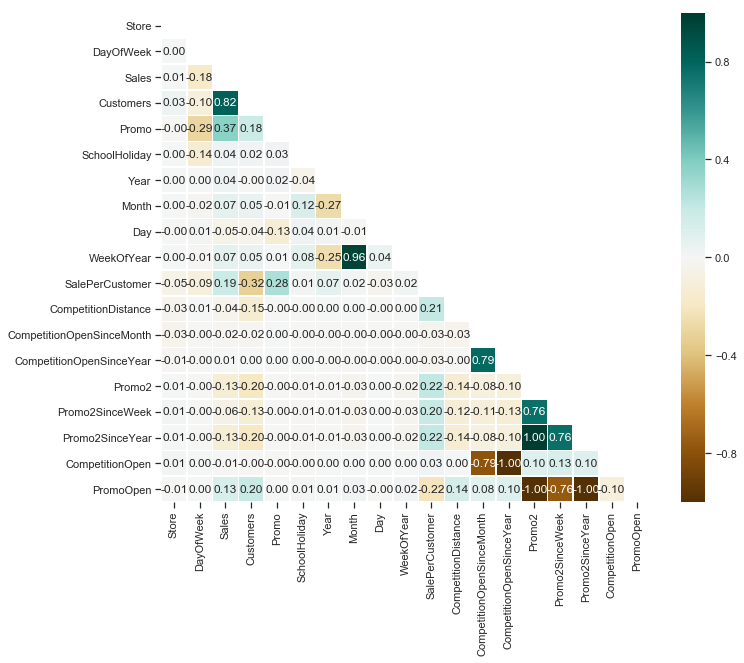

In [34]:
# HeatMap
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, annot = True, square = True, linewidths = 0.5, ax = ax, cmap = "BrBG", fmt='.2f')      
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.

However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

C:\DataScience\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


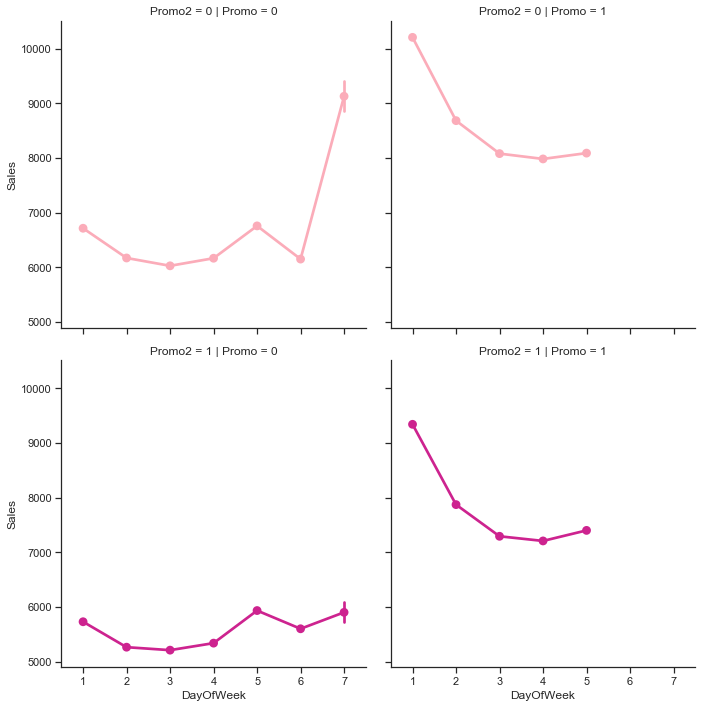

In [35]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

There are several things here:

In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

### Conclusion of EDA
- The most selling and crowded StoreType is A.
- The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. We could also assume that the stores of this types are situated in the rural areas, so that customers prefer buying more but less often.
- Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for small things. - Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.
- Customers tends to buy more on Mondays when there's one promotion running (Promo) and on Sundays when there is no promotion at all (both Promo and Promo1 are equal to 0).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

# Time-Series Analysis per Store Type

ARIMA is one of the most classic time series forecasting models. During the modeling process, we mainly want to find 3 parameters. Auto-regression(AR) term, namly the lags of previous value; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term.
In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model

### Seasonality

We take four stores from store types to represent their group:

- Store number 2 for StoreType A
- Store number 85 for StoreType B,
- Store number 1 for StoreType C
- Store number 13 for StoreType D.

It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [36]:
train_store.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month    ...      Assortment  CompetitionDistance  \
0              1  2015      7    ...               a               1270.0   
1              1  2015      7    ...               a               1270.0   
2              1  2015      7    ...               a               1270.0   
3              1  2015      7    ...               a               1270.0   
4              1  2015      7    ...               a               1270.0   

   CompetitionOpenSinceMonth CompetitionOpenSinceYear Promo2  Promo2SinceWeek  \
0                        9.0                   2008.0      0              0.0   
1                        9.0                   2008.0      0              0.0   
2                        9.0                   2008.0      0              0.0   
3                        9.0                   2008.0      0              0.0   
4                        9.0                   2008.0      0              0.0   

   Promo2SinceYear  PromoInterval  CompetitionOpen  PromoOpen  
0              0.0              0             82.0   24187.75  
1              0.0              0             82.0   24187.75  
2              0.0              0             82.0   24187.75  
3              0.0              0             82.0   24187.75  
4              0.0              0             82.0   24187.75  

[5 rows x 24 columns]

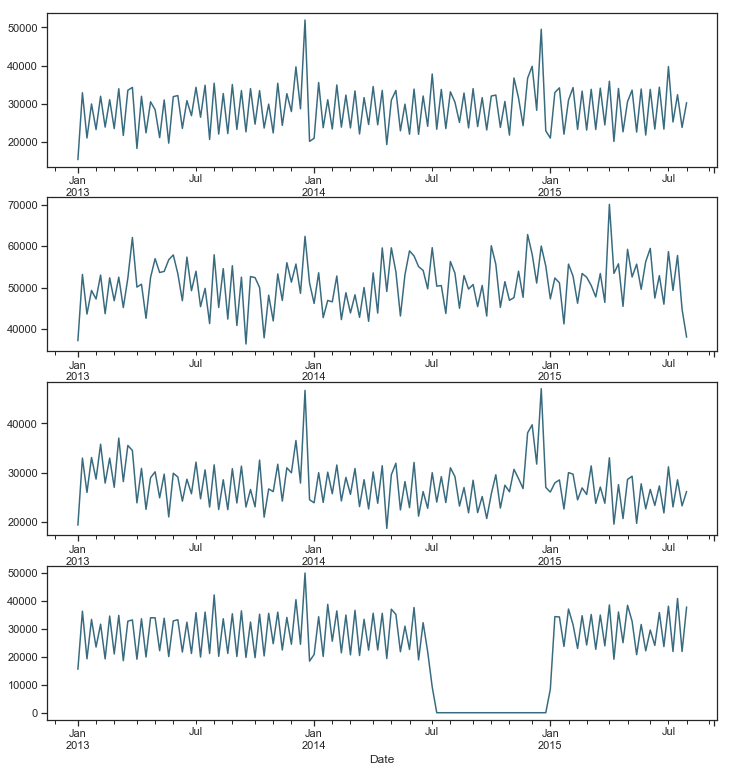

In [37]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales']
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

### Yearly trend
The next thing to check the presence of a trend in series.
Another tool to visualize the data is the seasonal_decompose function in statsmodel. With this, the trend and seasonality become even more obvious.

In [38]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

## Stationarize the data:

When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test.

if the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. Below is code that will help you visualize the time series and test for stationarity.

In [39]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [40]:
from scipy import stats
from scipy.stats import normaltest
def residual_plot(model):

    resid = model.resid
    print(normaltest(resid))
    # returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
    # the residual is not a normal distribution

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    #Now plot the distribution using 
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')


    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

In [41]:
test_stationarity(sales_a)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.292708
p-value                          0.000006
#Lags Used                      17.000000
Number of Observations Used    766.000000
Critical Value (1%)             -3.438916
Critical Value (5%)             -2.865321
Critical Value (10%)            -2.568783
dtype: float64


So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data.
The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.

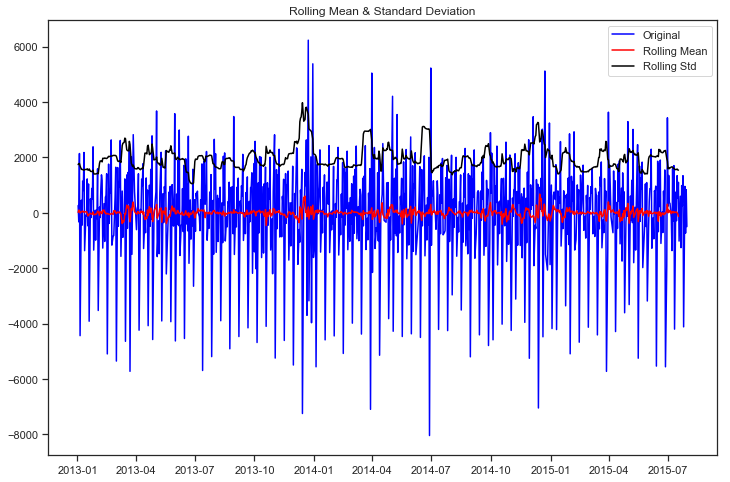

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.219964e+01
p-value                        1.231658e-22
#Lags Used                     1.600000e+01
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [42]:
first_diff_a = sales_a - sales_a.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)

In [43]:
test_stationarity(sales_b)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -4.934210
p-value                          0.000030
#Lags Used                      20.000000
Number of Observations Used    921.000000
Critical Value (1%)             -3.437470
Critical Value (5%)             -2.864683
Critical Value (10%)            -2.568444
dtype: float64


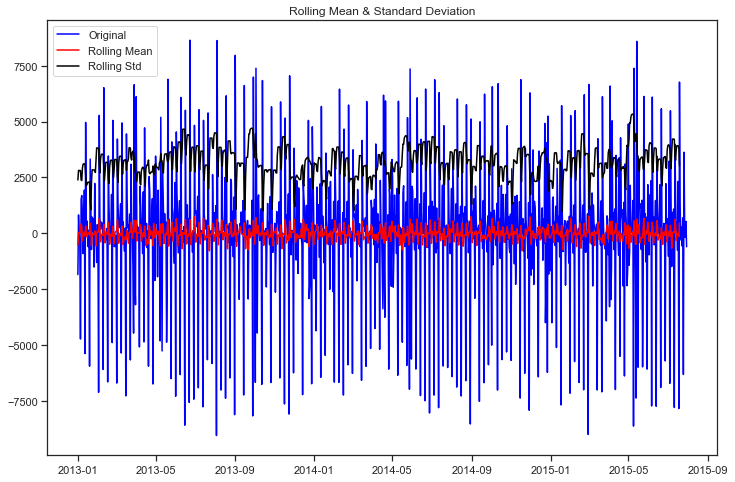

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.102941e+01
p-value                        5.718144e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.200000e+02
Critical Value (1%)           -3.437478e+00
Critical Value (5%)           -2.864687e+00
Critical Value (10%)          -2.568445e+00
dtype: float64


In [44]:
first_diff_b = sales_b - sales_b.shift(1)
first_diff_b = first_diff_b.dropna(inplace = False)
test_stationarity(first_diff_b, window = 12)

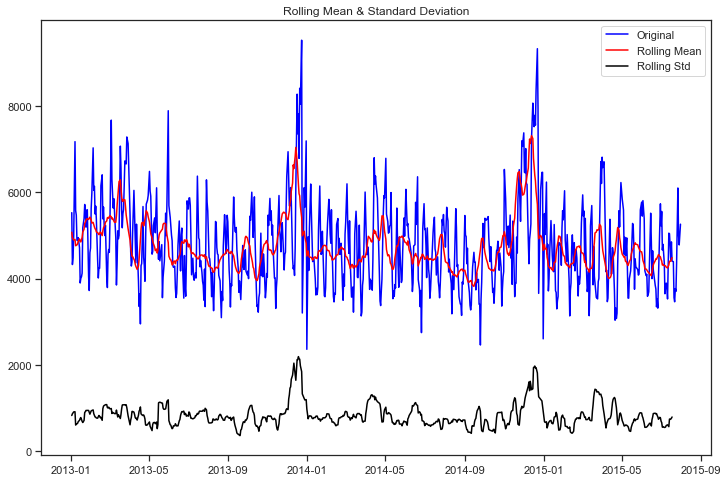

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.412786
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64


In [45]:
test_stationarity(sales_c)

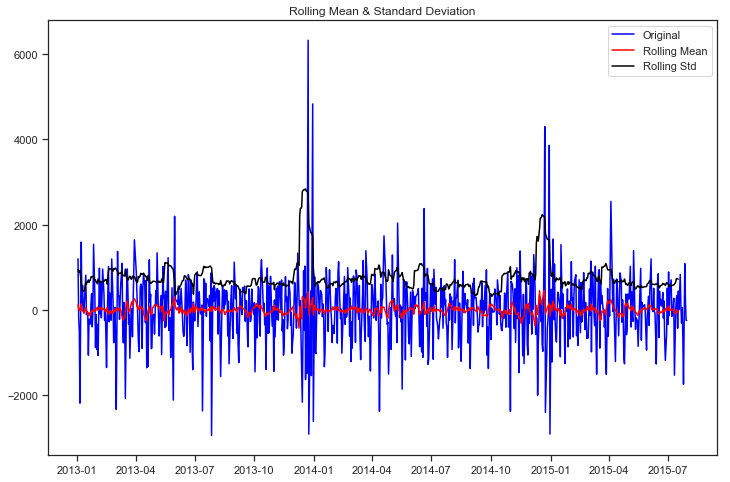

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.042084e+01
p-value                        1.706353e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.590000e+02
Critical Value (1%)           -3.438995e+00
Critical Value (5%)           -2.865355e+00
Critical Value (10%)          -2.568802e+00
dtype: float64


In [46]:
first_diff_c = sales_c - sales_c.shift(1)
first_diff_c = first_diff_c.dropna(inplace = False)
test_stationarity(first_diff_c, window = 12)

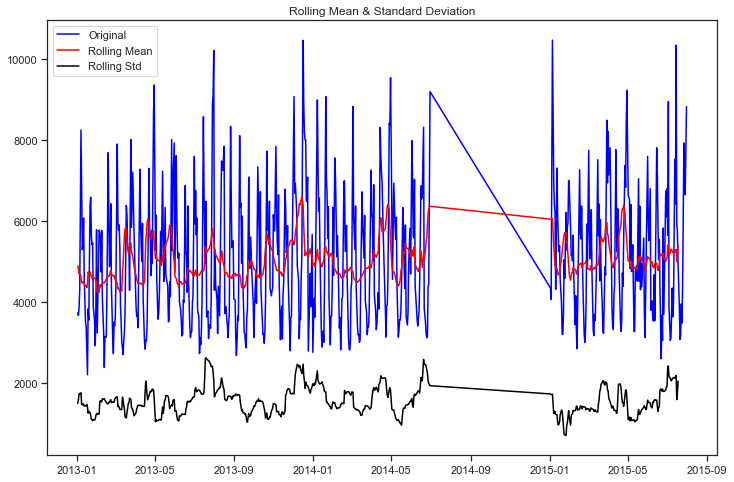

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.321001e+00
p-value                        3.066380e-08
#Lags Used                     1.200000e+01
Number of Observations Used    6.080000e+02
Critical Value (1%)           -3.441151e+00
Critical Value (5%)           -2.866305e+00
Critical Value (10%)          -2.569308e+00
dtype: float64


In [47]:
test_stationarity(sales_d)

In [48]:
first_diff_d = sales_d - sales_d.shift(1)
first_diff_d = first_diff_d.dropna(inplace = False)
test_stationarity(first_diff_d, window = 12)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.553455e+00
p-value                        2.535472e-16
#Lags Used                     1.900000e+01
Number of Observations Used    6.000000e+02
Critical Value (1%)           -3.441296e+00
Critical Value (5%)           -2.866369e+00
Critical Value (10%)          -2.569342e+00
dtype: float64


#### Plot the ACF and PACF charts and find the optimal parameters

The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many rules and best practices about how to select the appropriate AR, MA, SAR, and MAR terms for the model. The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs to select the proper terms. The big issue as with all models is that you don’t want to overfit your model to the data by using too many terms.

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [49]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

In [50]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(first_diff_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(first_diff_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(first_diff_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(first_diff_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(first_diff_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(first_diff_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(first_diff_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(first_diff_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

- Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
- Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

### Build Model:

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 11 lags the AR is significant. Which means, we can use AR = 11

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.


In [51]:
arima_mod_a = sm.tsa.ARIMA(sales_a, (11,1,0)).fit(disp=False)
print(arima_mod_a.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  783
Model:                ARIMA(11, 1, 0)   Log Likelihood               -6699.651
Method:                       css-mle   S.D. of innovations           1253.922
Date:                Fri, 14 Dec 2018   AIC                          13425.301
Time:                        18:17:25   BIC                          13485.922
Sample:                             1   HQIC                         13448.613
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3911      6.107     -0.064      0.949     -12.361      11.579
ar.L1.D.Sales     -0.7266      0.032    -22.484      0.000      -0.790      -0.663
ar.L2.D.Sales     -0.5604      0.037

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

NormaltestResult(statistic=41.75774333077284, pvalue=8.558964939451239e-10)


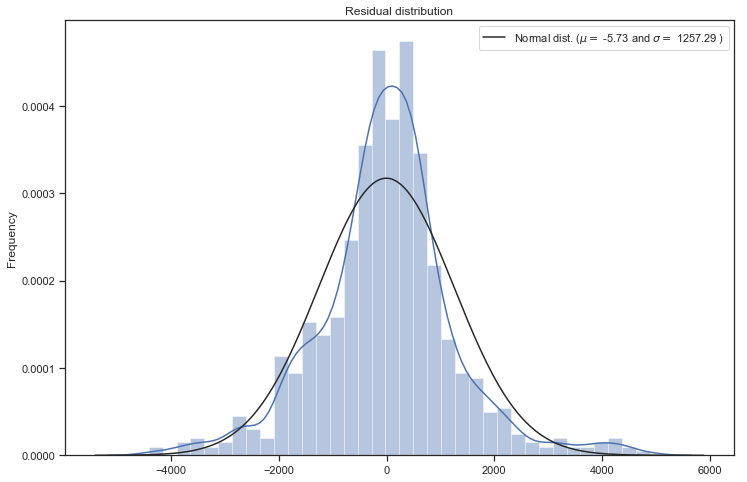

In [52]:
residual_plot(arima_mod_a)

In [53]:
sarima_mod_a = sm.tsa.statespace.SARIMAX(sales_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.912
Date:                             Fri, 14 Dec 2018   AIC                          13329.824
Time:                                     18:19:45   BIC                          13394.891
Sample:                                          0   HQIC                         13354.863
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6446      0.027    -23.711      0.000      -0.698      -0.591
ar.L2         -0.4139      

In [54]:
residual_plot(sarima_mod_a)

NormaltestResult(statistic=53.722657817646876, pvalue=2.1591015953711943e-12)


In [55]:
print(sales_a.shape)
sales_a.head()

(784,)


Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

In [56]:
sales_a_reindex = sales_a.reindex(index=sales_a.index[::-1])

In [57]:
sales_a_reindex

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
2013-01-08    6318.0
2013-01-09    6763.0
2013-01-10    5618.0
2013-01-11    4810.0
2013-01-12    2630.0
2013-01-14    3995.0
2013-01-15    4075.0
2013-01-16    4198.0
2013-01-17    2973.0
2013-01-18    3441.0
2013-01-19    2399.0
2013-01-21    6311.0
2013-01-22    5803.0
2013-01-23    5974.0
2013-01-24    5091.0
2013-01-25    4589.0
2013-01-26    2205.0
2013-01-28    3549.0
2013-01-29    3461.0
2013-01-30    4446.0
2013-01-31    4340.0
2013-02-01    4545.0
2013-02-02    2956.0
2013-02-04    6480.0
2013-02-05    6269.0
               ...  
2015-06-27    2404.0
2015-06-29    7961.0
2015-06-30    9863.0
2015-07-01    6431.0
2015-07-02    6189.0
2015-07-03    4838.0
2015-07-04    4475.0
2015-07-06    4132.0
2015-07-07    4313.0
2015-07-08    5676.0
2015-07-09    4082.0
2015-07-10    4384.0
2015-07-11    2677.0
2015-07-13    6874.0
2015-07-14    6122.0
2015-07-15    6406.0
2015-07-

In [58]:
mydata_a = sales_a_reindex
#mydata_a = sales_a_reindex.loc['2013-01-02':'2015-01-21']
#mydata_test = data.loc['2017-01-01':]

In [59]:
print(mydata_a)

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
2013-01-08    6318.0
2013-01-09    6763.0
2013-01-10    5618.0
2013-01-11    4810.0
2013-01-12    2630.0
2013-01-14    3995.0
2013-01-15    4075.0
2013-01-16    4198.0
2013-01-17    2973.0
2013-01-18    3441.0
2013-01-19    2399.0
2013-01-21    6311.0
2013-01-22    5803.0
2013-01-23    5974.0
2013-01-24    5091.0
2013-01-25    4589.0
2013-01-26    2205.0
2013-01-28    3549.0
2013-01-29    3461.0
2013-01-30    4446.0
2013-01-31    4340.0
2013-02-01    4545.0
2013-02-02    2956.0
2013-02-04    6480.0
2013-02-05    6269.0
               ...  
2015-06-27    2404.0
2015-06-29    7961.0
2015-06-30    9863.0
2015-07-01    6431.0
2015-07-02    6189.0
2015-07-03    4838.0
2015-07-04    4475.0
2015-07-06    4132.0
2015-07-07    4313.0
2015-07-08    5676.0
2015-07-09    4082.0
2015-07-10    4384.0
2015-07-11    2677.0
2015-07-13    6874.0
2015-07-14    6122.0
2015-07-15    6406.0
2015-07-

In [60]:
temp_df =pd.DataFrame(mydata_a)

In [61]:
mydata_a = temp_df

In [62]:
sarima_mod_a_train = sm.tsa.statespace.SARIMAX(mydata_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a_train.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.967
Date:                             Fri, 14 Dec 2018   AIC                          13329.933
Time:                                     18:22:12   BIC                          13395.001
Sample:                                          0   HQIC                         13354.973
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6429      0.029    -22.226      0.000      -0.700      -0.586
ar.L2         -0.4115      

NormaltestResult(statistic=90.08676604334235, pvalue=2.740989093278687e-20)


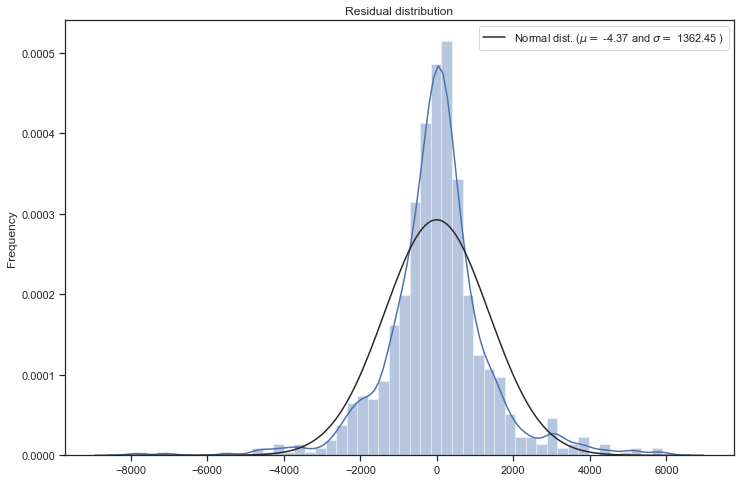

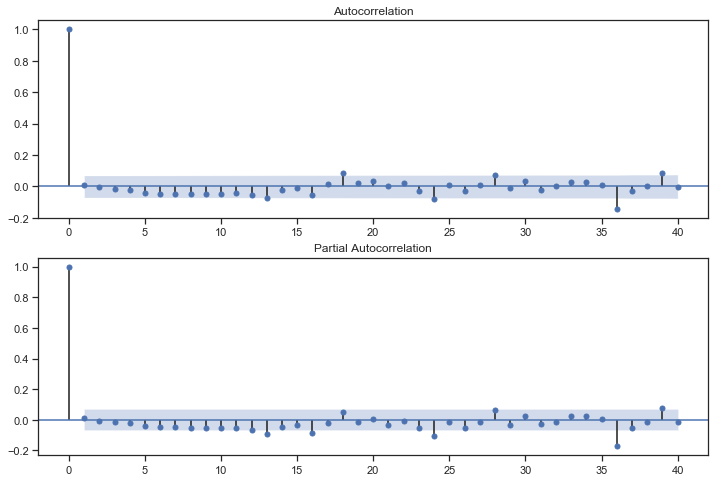

In [63]:
residual_plot(sarima_mod_a_train)

Text(0.5,0,'Time')

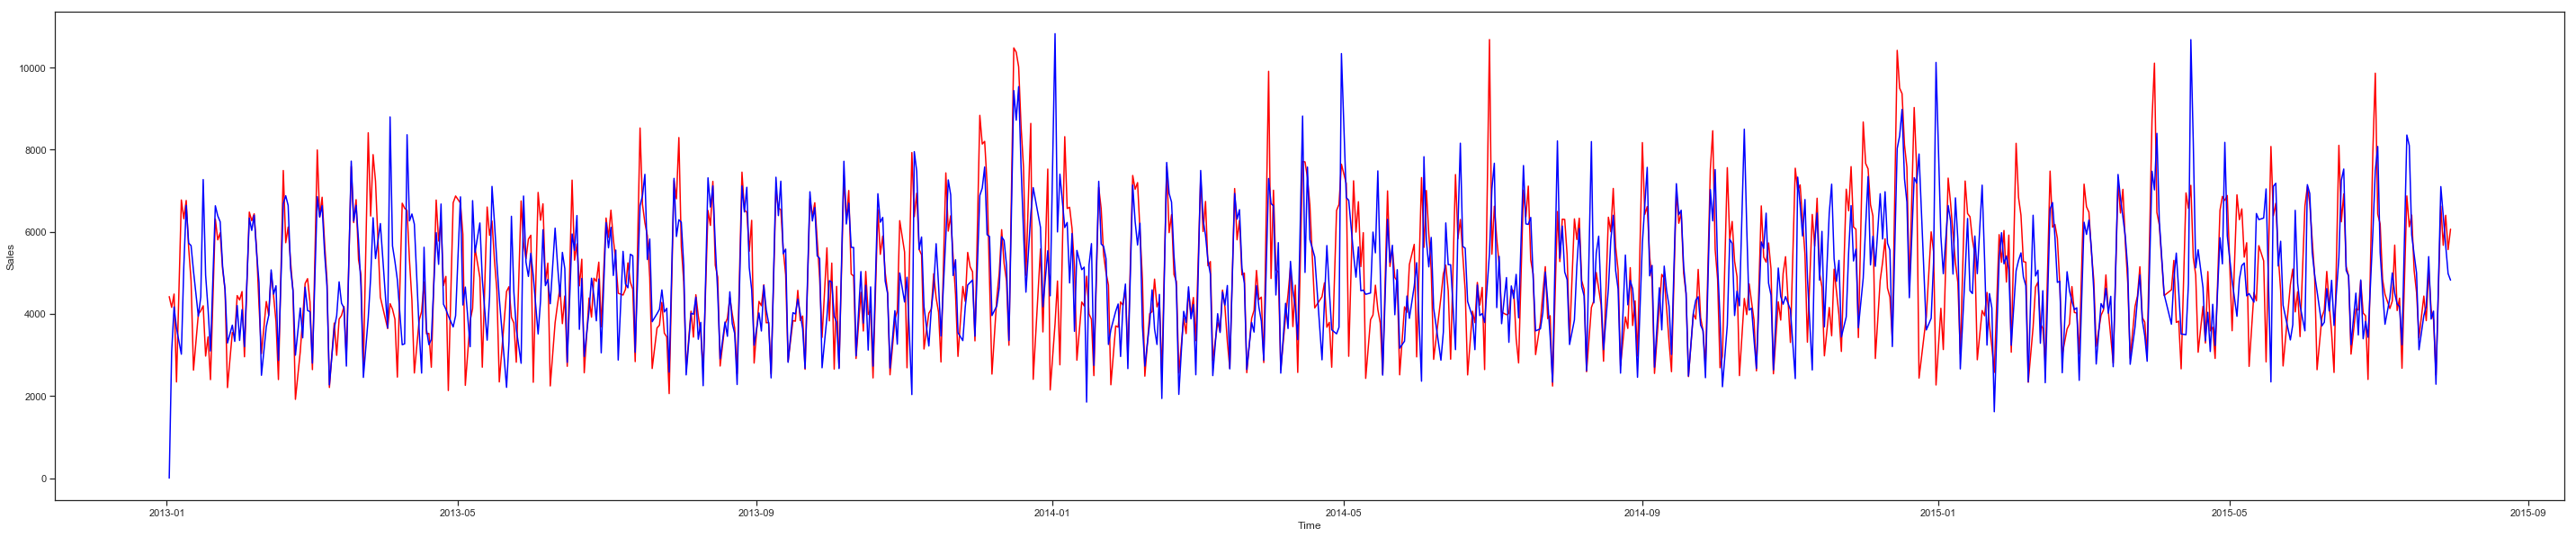

In [64]:
plt.figure(figsize=(50,10))
plt.plot(mydata_a, c='red')
plt.plot(sarima_mod_a_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Date
2015-01-22    4495.672299
2015-01-23    4145.600166
2015-01-24    1617.485825
2015-01-26    5316.761307
2015-01-27    5977.404558
2015-01-28    5219.779643
2015-01-29    5409.370187
2015-01-30    5090.833499
2015-01-31    3236.061234
2015-02-02    5050.081227
2015-02-03    5302.445296
2015-02-04    5486.514615
2015-02-05    4902.057939
2015-02-06    4687.441565
2015-02-07    2345.855753
2015-02-09    6403.447826
2015-02-10    4923.537823
2015-02-11    5064.697110
2015-02-12    3285.514106
2015-02-13    4565.638426
2015-02-14    2324.422636
2015-02-16    6555.588835
2015-02-17    6712.403413
2015-02-18    5874.576486
2015-02-19    4767.790455
2015-02-20    4794.761554
2015-02-21    2567.429070
2015-02-23    5027.936147
2015-02-24    4560.872217
2015-02-25    4307.514767
                 ...     
2015-06-27    3431.689898
2015-06-29    5979.253046
2015-06-30    7483.307885
2015-07-01    8077.858343
2015-07-02    5491.972881
2015-07-03    4577.245838
2015-07-04    3747.788528
2015-07

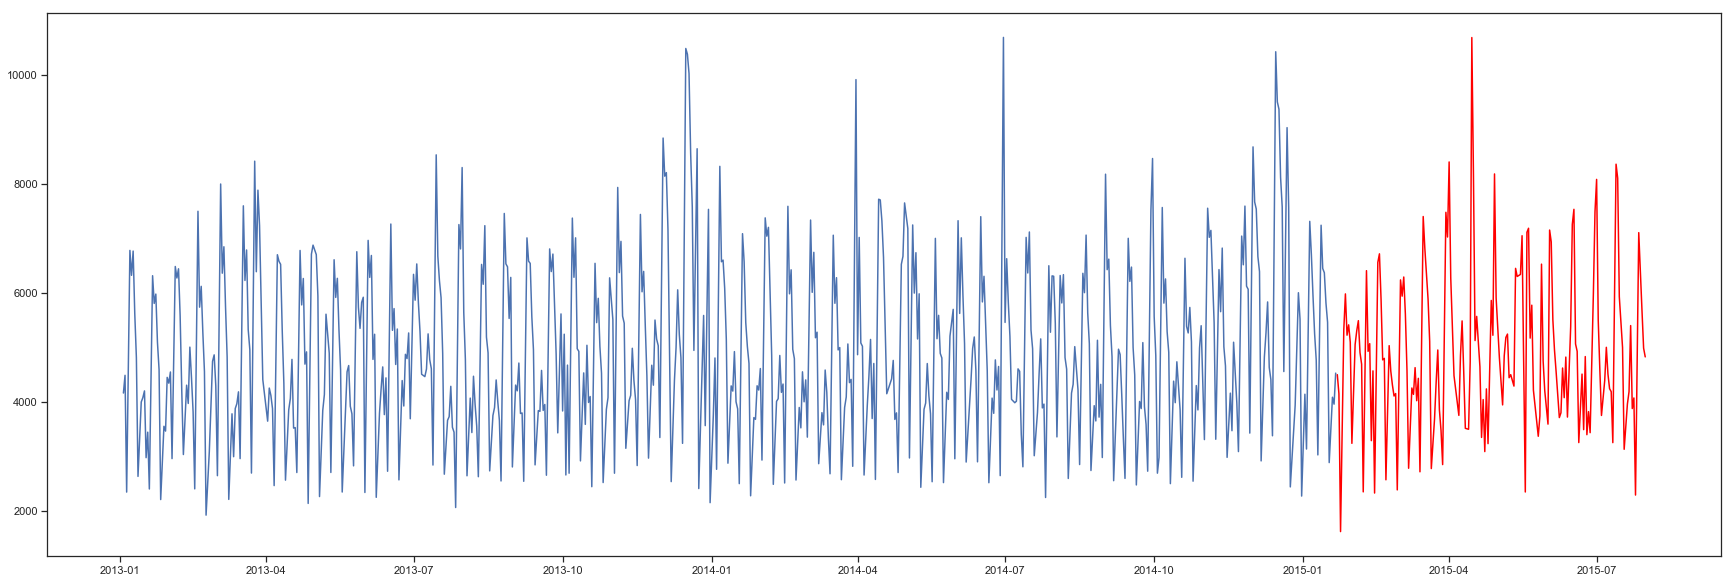

In [65]:
#forecast = sarima_mod_a_train.predict(start =mydata_a.loc['2015-01-21':], dynamic= True)  
#plt.plot(mydata_a.loc['2013-01-02':'2015-01-21'])
plt.figure(figsize=(30,10))
forecast = sarima_mod_a_train.predict(start = 625, end = 783, dynamic= False)  
plt.plot(mydata_a.iloc[1:625])
plt.plot(forecast, c = "red")
forecast
#pred_ci = forecast.conf_int()
#pred_ci.head()

#start_index = 624
#end_index = 784
#mydata_a['forecast'] = sarima_mod_a_train.predict(start = start_index, end= end_index, dynamic= True)  
#mydata_a[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [66]:
arima_mod_b = sm.tsa.ARIMA(sales_b, (1,1,0)).fit(disp=False)
print(arima_mod_b.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  941
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -8792.163
Method:                       css-mle   S.D. of innovations           2763.784
Date:                Fri, 14 Dec 2018   AIC                          17590.325
Time:                        18:22:52   BIC                          17604.866
Sample:                    07-30-2015   HQIC                         17595.868
                         - 01-01-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7949     61.463     -0.062      0.951    -124.260     116.670
ar.L1.D.Sales    -0.4664      0.029    -16.187      0.000      -0.523      -0.410
                                    Root

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


NormaltestResult(statistic=36.998161754988104, pvalue=9.245943912883087e-09)


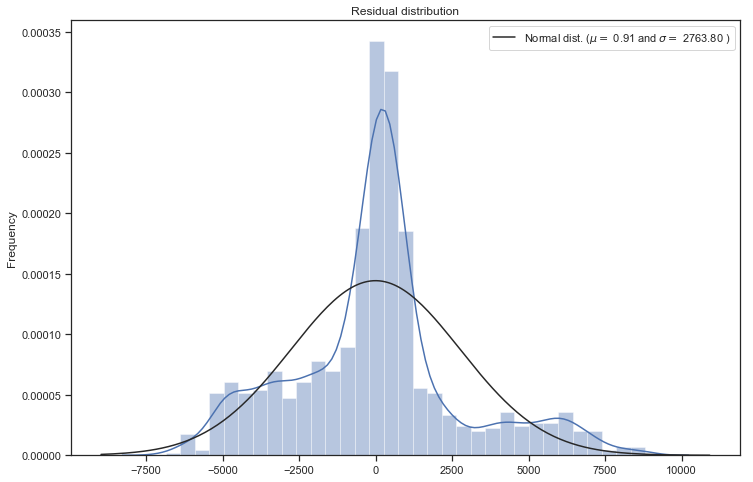

In [67]:
residual_plot(arima_mod_b)

In [68]:
sarima_mod_b = sm.tsa.statespace.SARIMAX(sales_b, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_b.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  942
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -8444.255
Date:                             Fri, 14 Dec 2018   AIC                          16916.511
Time:                                     18:24:01   BIC                          16984.188
Sample:                                 07-31-2015   HQIC                         16942.325
                                      - 01-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5801      0.048    -12.188      0.000      -0.673      -0.487
ar.L2         -0.4547      

NormaltestResult(statistic=38.46752092345487, pvalue=4.434901364290572e-09)


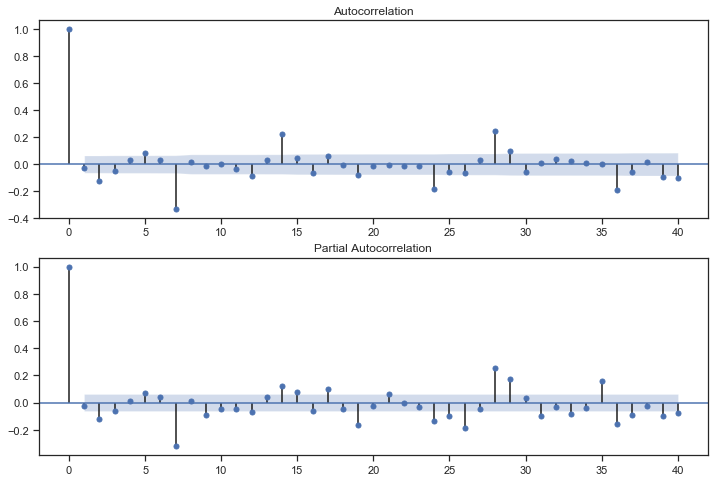

In [69]:
residual_plot(sarima_mod_b)

In [70]:
print(sales_b.shape)
sales_b.head()

(942,)


Date
2015-07-31    7791.0
2015-07-30    7187.0
2015-07-29    7719.0
2015-07-28    7533.0
2015-07-27    7788.0
Name: Sales, dtype: float64

In [71]:
sales_b_reindex = sales_b.reindex(index=sales_b.index[::-1])

In [ ]:
#sales_b_reindex.head(100)

In [72]:
mydata_b = sales_b_reindex

In [73]:
temp_df =pd.DataFrame(mydata_b)

In [74]:
mydata_b = temp_df

In [75]:
sarima_mod_b_train = sm.tsa.statespace.SARIMAX(mydata_b, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_b_train.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  942
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -8444.259
Date:                             Fri, 14 Dec 2018   AIC                          16916.518
Time:                                     18:27:36   BIC                          16984.195
Sample:                                 01-01-2013   HQIC                         16942.332
                                      - 07-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5752      0.044    -13.215      0.000      -0.661      -0.490
ar.L2         -0.4420      

NormaltestResult(statistic=41.151994377232285, pvalue=1.158665194691944e-09)


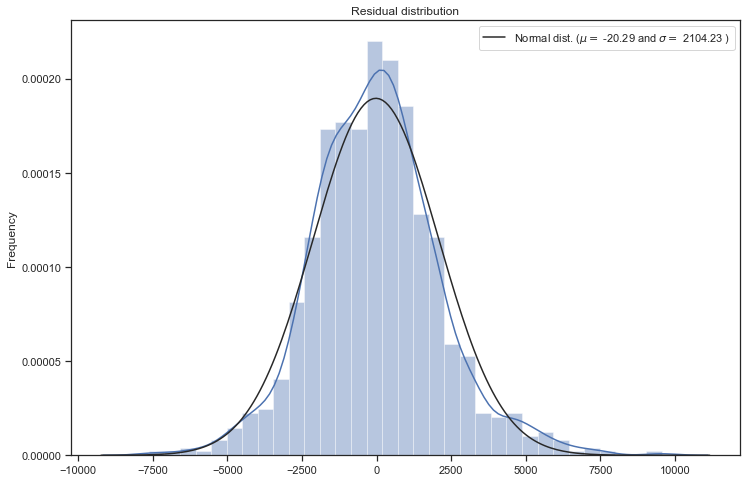

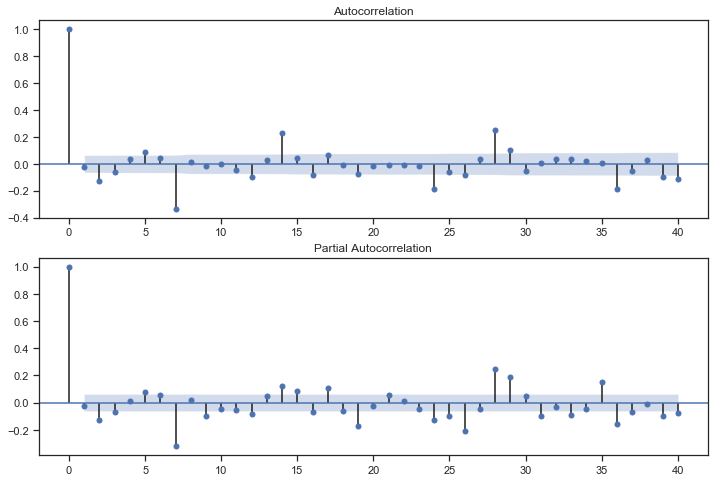

In [76]:
residual_plot(sarima_mod_b_train)

In [77]:
plt.figure(figsize=(50,10))
plt.plot(mydata_b, c='red')
plt.plot(sarima_mod_b_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Text(0.5,0,'Time')

In [78]:
plt.figure(figsize=(30,10))
forecast = sarima_mod_b_train.predict(start = 755, end = 941, dynamic= False)  
plt.plot(mydata_b.iloc[1:755])
plt.plot(forecast, c = "red")
forecast

2015-01-26     3053.668045
2015-01-27     7456.630855
2015-01-28     7472.146245
2015-01-29     6100.533280
2015-01-30     6684.795989
2015-01-31     6102.886377
2015-02-01     6390.701013
2015-02-02    11123.583300
2015-02-03     6799.426084
2015-02-04     7437.608709
2015-02-05     6014.643170
2015-02-06     4607.911394
2015-02-07     5958.202232
2015-02-08    11986.192386
2015-02-09     7210.339082
2015-02-10     6610.543659
2015-02-11     6125.799073
2015-02-12     5674.123349
2015-02-13     8579.653363
2015-02-14     4773.892435
2015-02-15     9861.001451
2015-02-16     6754.580771
2015-02-17     8092.788385
2015-02-18     6000.486963
2015-02-19     7928.656109
2015-02-20     6894.683125
2015-02-21     4969.286794
2015-02-22     8716.242020
2015-02-23     9243.493492
2015-02-24     6043.899883
                  ...     
2015-07-02     6330.777661
2015-07-03     6676.048102
2015-07-04     5030.240070
2015-07-05    10087.458925
2015-07-06     9059.937794
2015-07-07     6192.784940
2

In [79]:
arima_mod_c = sm.tsa.ARIMA(sales_c, (11,1,0)).fit(disp=False)
print(arima_mod_c.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                ARIMA(11, 1, 0)   Log Likelihood               -6212.916
Method:                       css-mle   S.D. of innovations            695.917
Date:                Fri, 14 Dec 2018   AIC                          12451.832
Time:                        18:27:41   BIC                          12512.403
Sample:                             1   HQIC                         12475.129
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7173      6.686      0.107      0.915     -12.387      13.821
ar.L1.D.Sales     -0.3051      0.036     -8.549      0.000      -0.375      -0.235
ar.L2.D.Sales     -0.2433      0.037

NormaltestResult(statistic=165.0962590690485, pvalue=1.4118964677526082e-36)


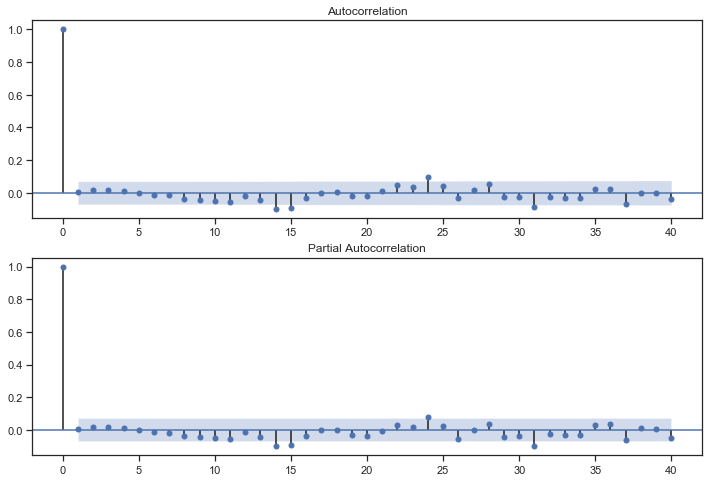

In [80]:
residual_plot(arima_mod_c)

In [81]:
sarima_mod_c = sm.tsa.statespace.SARIMAX(sales_c, trend='n', order=(11,1,0)).fit()
print(sarima_mod_c.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                  781
Model:              SARIMAX(11, 1, 0)   Log Likelihood               -6211.688
Date:                Fri, 14 Dec 2018   AIC                          12447.376
Time:                        18:27:44   BIC                          12503.287
Sample:                             0   HQIC                         12468.880
                                - 781                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3038      0.028    -10.802      0.000      -0.359      -0.249
ar.L2         -0.2446      0.043     -5.744      0.000      -0.328      -0.161
ar.L3         -0.3865      0.036    -10.709      0.0

NormaltestResult(statistic=251.24074653882903, pvalue=2.778210027311039e-55)


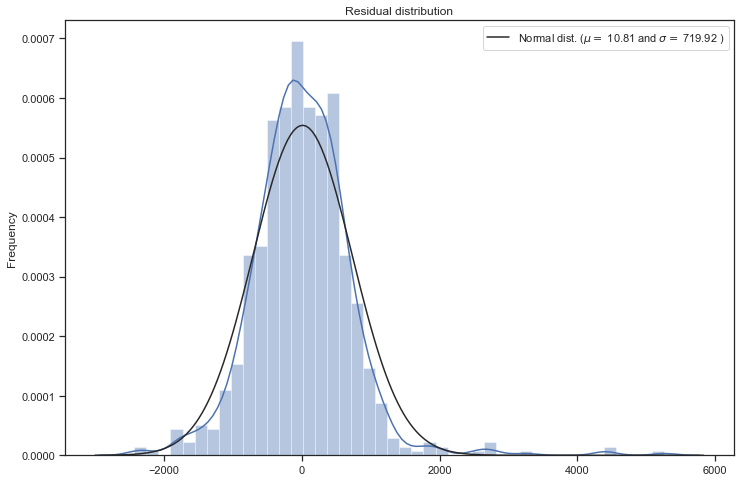

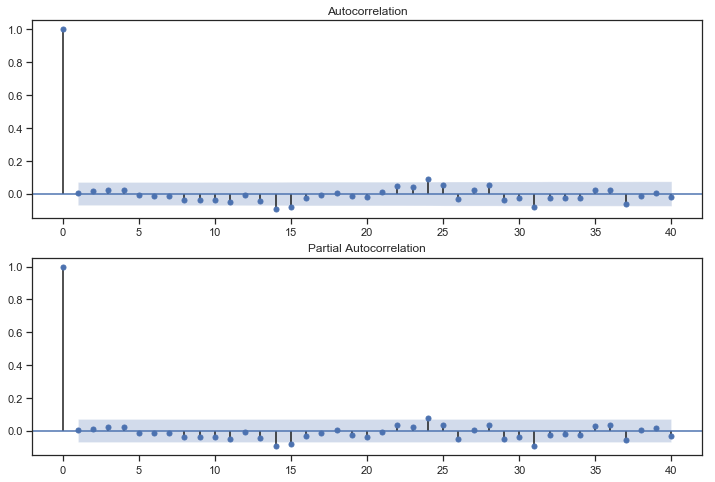

In [82]:
residual_plot(sarima_mod_c)

In [83]:
sales_c_reindex = sales_c.reindex(index=sales_c.index[::-1])

In [84]:
mydata_c = sales_c_reindex

In [85]:
temp_df =pd.DataFrame(mydata_c)

In [86]:
mydata_c = temp_df

In [87]:
sarima_mod_c_train = sm.tsa.statespace.SARIMAX(mydata_c, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_c_train.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  781
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6195.593
Date:                             Fri, 14 Dec 2018   AIC                          12419.186
Time:                                     18:28:00   BIC                          12484.199
Sample:                                          0   HQIC                         12444.209
                                             - 781                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3189      0.028    -11.560      0.000      -0.373      -0.265
ar.L2         -0.2187      

In [88]:
residual_plot(sarima_mod_c_train)

NormaltestResult(statistic=109.54336680315478, pvalue=1.6329020495415617e-24)


In [89]:
print(sales_c.shape)
sales_c.head()

(781,)


Date
2015-07-31    5263.0
2015-07-30    5020.0
2015-07-29    4782.0
2015-07-28    5011.0
2015-07-27    6102.0
Name: Sales, dtype: float64

Text(0.5,0,'Time')

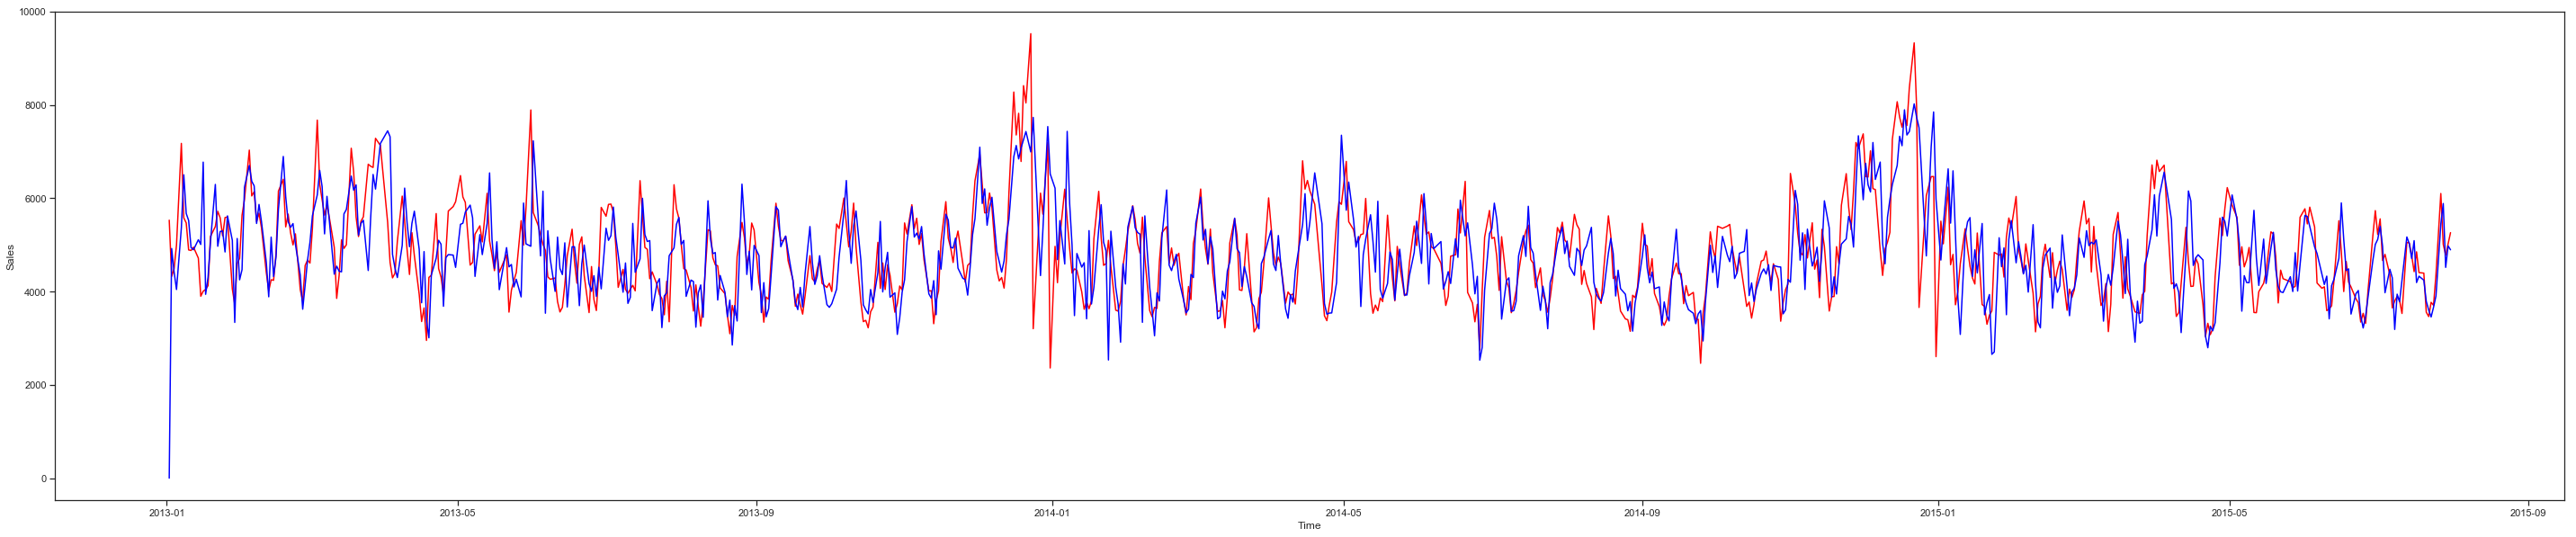

In [90]:
plt.figure(figsize=(50,10))
plt.plot(mydata_c, c='red')
plt.plot(sarima_mod_c_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Date
2015-01-24    2704.998460
2015-01-26    5153.097288
2015-01-27    4533.235988
2015-01-28    4936.088006
2015-01-29    3503.130950
2015-01-30    5114.904808
2015-01-31    5521.347539
2015-02-02    4615.993045
2015-02-03    5067.209620
2015-02-04    4754.186213
2015-02-05    4378.063806
2015-02-06    4564.127126
2015-02-07    3987.992640
2015-02-09    5434.326146
2015-02-10    4179.379657
2015-02-11    3348.987147
2015-02-12    3222.068295
2015-02-13    4498.746813
2015-02-14    4781.561794
2015-02-16    4931.809035
2015-02-17    3643.201904
2015-02-18    4312.525500
2015-02-19    3983.390915
2015-02-20    4120.935097
2015-02-21    5214.232209
2015-02-23    4106.861841
2015-02-24    3482.001238
2015-02-25    3991.795090
2015-02-26    4074.951574
2015-02-27    4354.352944
                 ...     
2015-06-27    3882.111781
2015-06-29    4668.960096
2015-06-30    5010.003574
2015-07-01    5117.885795
2015-07-02    5398.960681
2015-07-03    4969.565706
2015-07-04    3974.870474
2015-07

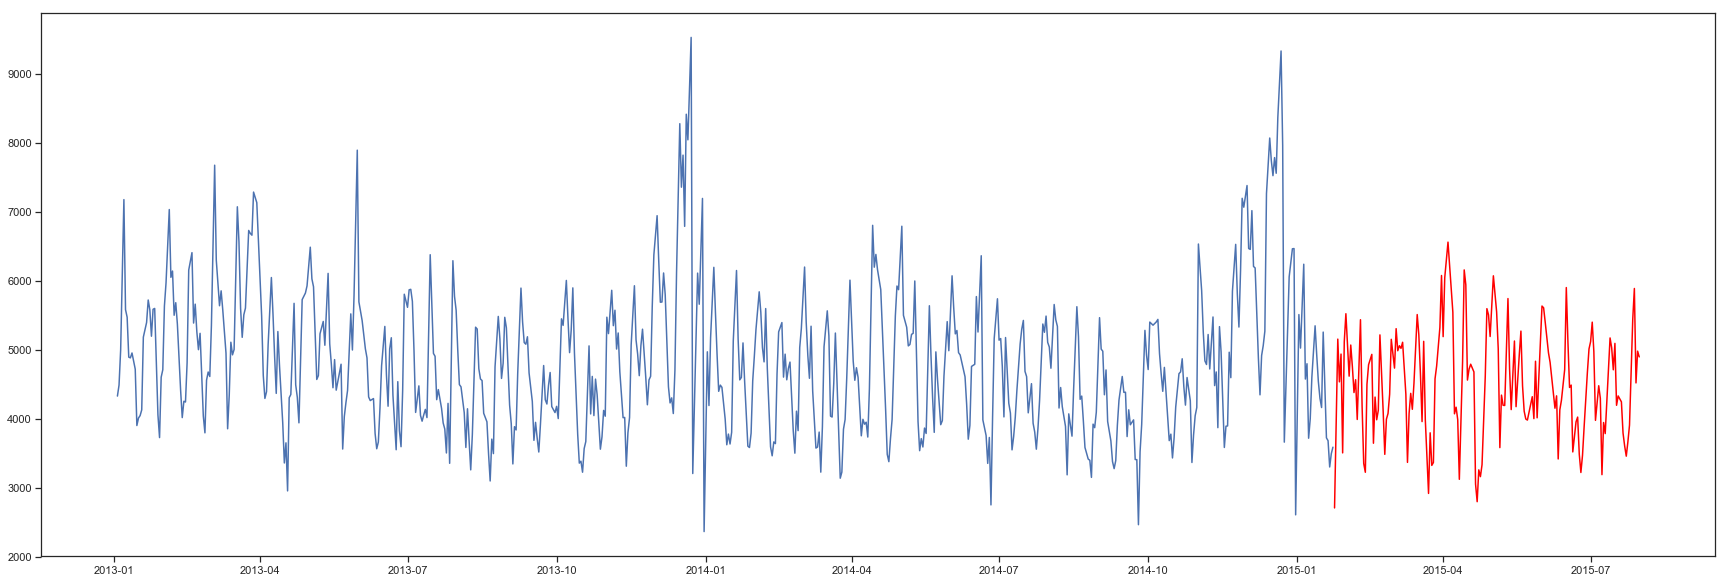

In [91]:
plt.figure(figsize=(30,10))
forecast = sarima_mod_c_train.predict(start = 625, end = 780, dynamic= False)  
plt.plot(mydata_c.iloc[1:625])
plt.plot(forecast, c = "red")
forecast

In [92]:
arima_mod_d = sm.tsa.ARIMA(sales_d, (11,1,0)).fit(disp=False)
print(arima_mod_d.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  620
Model:                ARIMA(11, 1, 0)   Log Likelihood               -5280.576
Method:                       css-mle   S.D. of innovations           1206.234
Date:                Fri, 14 Dec 2018   AIC                          10587.151
Time:                        18:28:58   BIC                          10644.738
Sample:                             1   HQIC                         10609.536
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4547      8.357     -0.174      0.862     -17.834      14.924
ar.L1.D.Sales     -0.5783      0.039    -14.971      0.000      -0.654      -0.503
ar.L2.D.Sales     -0.4407      0.043

In [93]:
residual_plot(arima_mod_d)

NormaltestResult(statistic=59.577969476951026, pvalue=1.1556020579372309e-13)


In [94]:
sarima_mod_d = sm.tsa.statespace.SARIMAX(sales_d, trend='n', order=(11,1,0),seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_d.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  621
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5241.005
Date:                             Fri, 14 Dec 2018   AIC                          10510.009
Time:                                     18:29:23   BIC                          10571.752
Sample:                                          0   HQIC                         10534.030
                                             - 621                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5266      0.034    -15.644      0.000      -0.593      -0.461
ar.L2         -0.4017      

NormaltestResult(statistic=72.610650434753, pvalue=1.7092185376401854e-16)


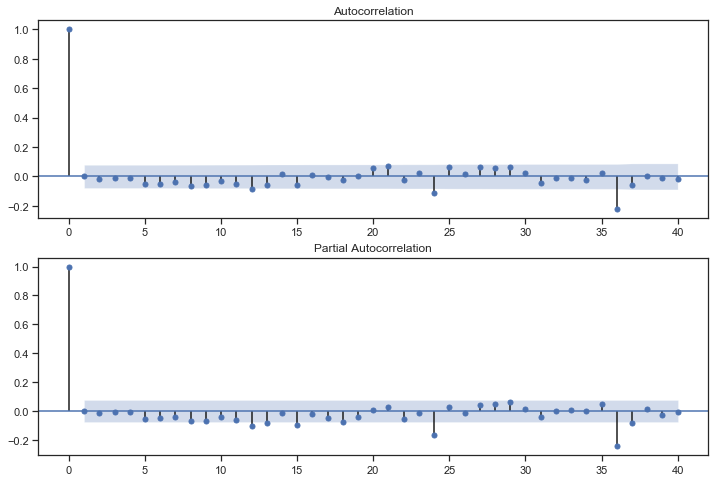

In [95]:
residual_plot(sarima_mod_d)

In [96]:
print(sales_d.shape)
sales_d.head()

(621,)


Date
2015-07-31    8821.0
2015-07-30    7648.0
2015-07-29    6648.0
2015-07-28    6819.0
2015-07-27    7926.0
Name: Sales, dtype: float64

In [97]:
sales_d_reindex = sales_d.reindex(index=sales_d.index[::-1])

In [98]:
mydata_d = sales_d_reindex

In [99]:
temp_df =pd.DataFrame(mydata_d)

In [100]:
mydata_d = temp_df

In [101]:
sarima_mod_d_train = sm.tsa.statespace.SARIMAX(mydata_d, trend='n', order=(11,1,0),seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_d_train.summary())

C:\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                  Statespace Model Results                                 
Dep. Variable:                               Sales   No. Observations:                  621
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5241.636
Date:                             Fri, 14 Dec 2018   AIC                          10511.273
Time:                                     18:29:47   BIC                          10573.015
Sample:                                          0   HQIC                         10535.294
                                             - 621                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5225      0.033    -16.067      0.000      -0.586      -0.459
ar.L2         -0.3988      

NormaltestResult(statistic=33.391082186672996, pvalue=5.613304876442583e-08)


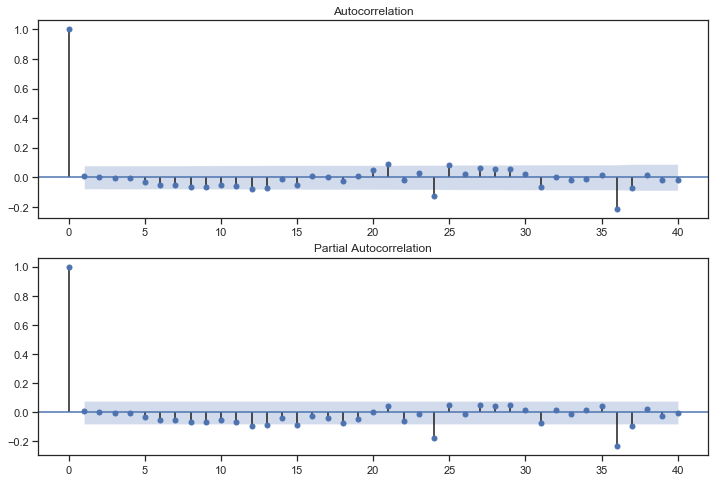

In [102]:
residual_plot(sarima_mod_d_train)

In [103]:
# Stote type D
plt.figure(figsize=(50,10))
plt.plot(mydata_d, c='red')
plt.plot(sarima_mod_d_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Text(0.5,0,'Time')

In [104]:
plt.figure(figsize=(30,10))
forecast = sarima_mod_d_train.predict(start = 495, end = 620, dynamic= False)  
plt.plot(mydata_d.iloc[1:495])
plt.plot(forecast, c = "red")
forecast

Date
2015-02-28    5994.136957
2015-03-02    6017.355197
2015-03-03    5805.801869
2015-03-04    5224.132702
2015-03-05    5346.121749
2015-03-06    5130.806588
2015-03-07    4692.072159
2015-03-09    3758.102170
2015-03-10    3426.664906
2015-03-11    3552.883891
2015-03-12    3884.718688
2015-03-13    5350.608667
2015-03-14    4930.608227
2015-03-16    6982.732800
2015-03-17    5777.742938
2015-03-18    5288.993616
2015-03-19    6306.448693
2015-03-20    5414.667262
2015-03-21    4479.953089
2015-03-23    2913.864148
2015-03-24    3507.387143
2015-03-25    3308.119736
2015-03-26    3445.148460
2015-03-27    4884.718482
2015-03-28    4863.295345
2015-03-30    7588.365238
2015-03-31    6218.284764
2015-04-01    6493.914304
2015-04-02    6649.868650
2015-04-04    7273.370903
                 ...     
2015-06-27    4884.003265
2015-06-29    6759.948405
2015-06-30    6705.015774
2015-07-01    5676.580449
2015-07-02    4929.034526
2015-07-03    6202.444166
2015-07-04    5632.813789
2015-07

#### Conclusion

#### Pros
- Arima can catch interactions between external features, which could improve the forecasting power of a model, But in case of Facebook prophet we cant use interactions term.

- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.

#### Cons
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.

- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

<h2>References</h2>
<ul>
    
<li>https://facebook.github.io/prophet/docs/installation.html</li>
<li>https://www.youtube.com/watch?v=95-HMzxsghY</li>
<li>https://blog.exploratory.io/an-introduction-to-time-series-forecasting-with-prophet-package-in-exploratory-129ed0c12112</li>
<li>https://facebook.github.io/prophet/docs/quick_start.html</li>
<li>https://www.kaggle.com/thie1e/exploratory-analysis-rossmann</li>
<li>https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet</li>
<li>https://www.kaggle.com/stefanozakher94/eda-and-forecasting-with-rfregressor-final-updated</li>
<li>http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/</li>
<li>https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c</li>
<li>https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/</li>


</ul>